In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.utils import remove_outliers_iqr
import pmdarima as pm

## Load data

In [2]:
%cd ..
data_folder = Path("data")
data_train = pd.read_csv(data_folder / "illinois_basing_train.csv")
data_test = pd.read_csv(data_folder / "illinois_basing_test.csv")

C:\Users\OGomez3\PycharmProjects\ml-challenge-2023


In [3]:
# %% Dates
data_train["SampleTimeUTC"] = pd.to_datetime(
    data_train["SampleTimeUTC"], format="%d/%m/%Y %H:%M"
)
data_test["SampleTimeUTC"] = pd.to_datetime(
    data_test["SampleTimeUTC"], format="%m/%d/%Y %H:%M"
)
# %% Set index
data_train.set_index("SampleTimeUTC", inplace=True)
data_test.set_index("SampleTimeUTC", inplace=True)

## Exclude Columns

In [4]:
# %% Exclude columns
cols_to_exclude = [
    "Avg_PLT_CO2InjRate_TPH",
    "Avg_VW1_Z03D6945Ps_psi",
    "Avg_VW1_Z03D6945Tp_F",
]
data_train.drop(cols_to_exclude, axis=1, inplace=True)
data_test.drop(cols_to_exclude[1:], axis=1, inplace=True)

# Plot data

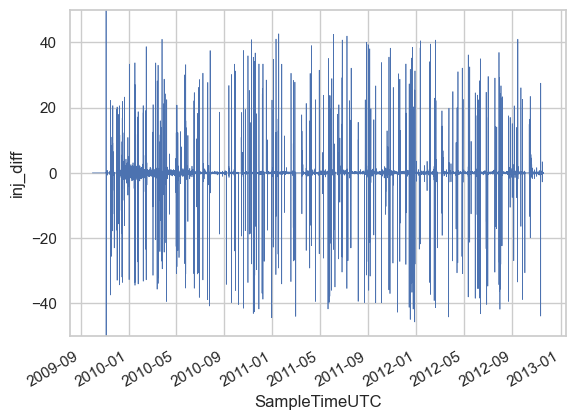

In [5]:
# %% Plot inj_diff column with time  using seaborn
sns.set()
sns.set_style("whitegrid")
sns.lineplot(x="SampleTimeUTC", y="inj_diff", data=data_train, linewidth=0.5)
plt.gcf().autofmt_xdate()
plt.ylim(-50, 50)
plt.show()

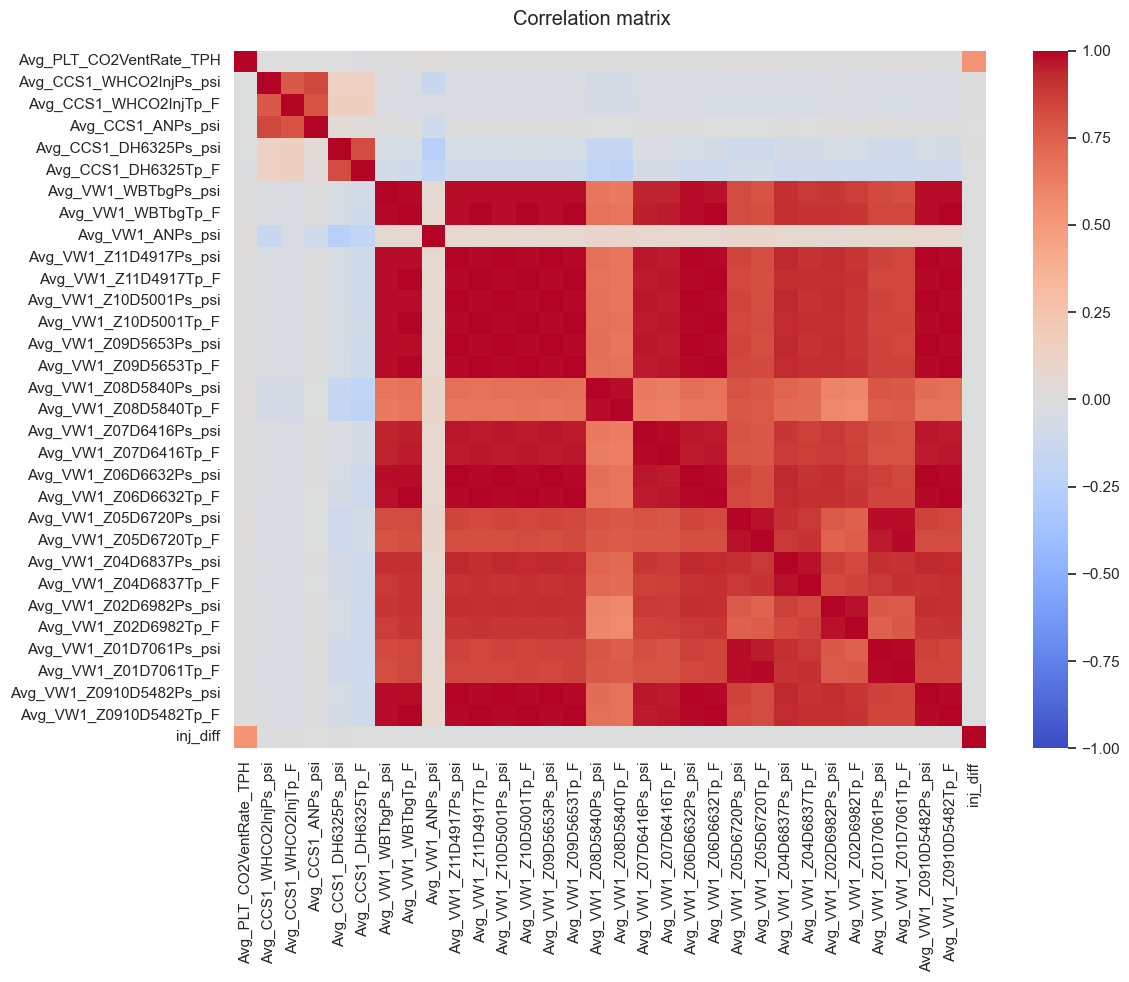

In [6]:
# %% Create a heatmap of the correlation matrix
corr = data_train.corr()
fig_1, ax_1 = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", ax=ax_1)
plt.suptitle("Correlation matrix")
plt.tight_layout()
plt.show()

## Remove columns
In this case we will remove the columns of the monitoring well VW1 for now since most of the columns are highly correlated with each other. We will check their influence later on after assembling the tsa modeling pipeline.

In [7]:
# %% Remove all the columns that contain the word "VW1"
cols_2 = [col for col in data_train.columns if "VW1" in col]
data_train_2 = data_train.drop(cols_2, axis=1)
data_test_2 = data_test.drop(cols_2, axis=1)

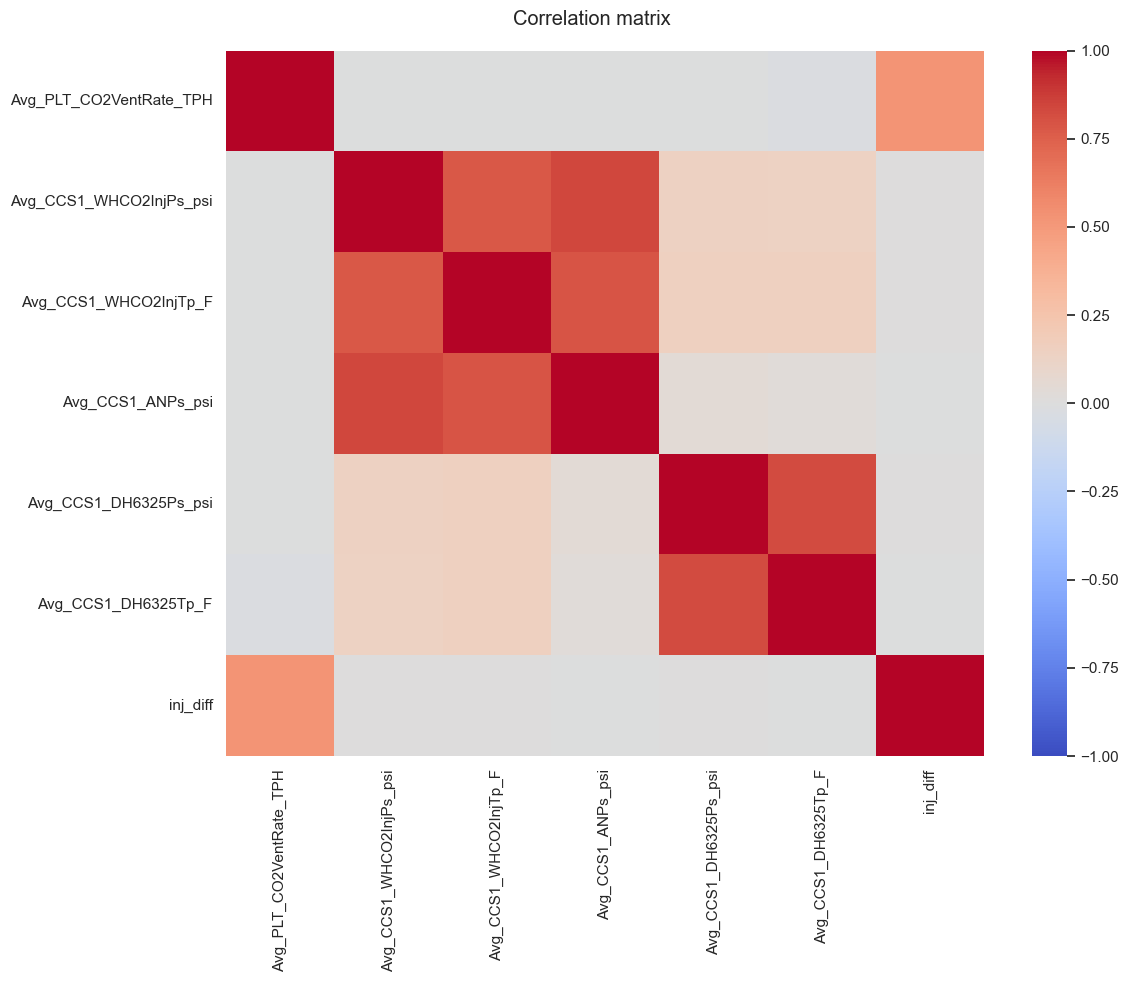

In [8]:
corr_2 = data_train_2.corr()
fig_2, ax_2 = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_2, vmin=-1, vmax=1, cmap="coolwarm", ax=ax_2)
plt.suptitle("Correlation matrix")
plt.tight_layout()
plt.show()

## Remove outliers

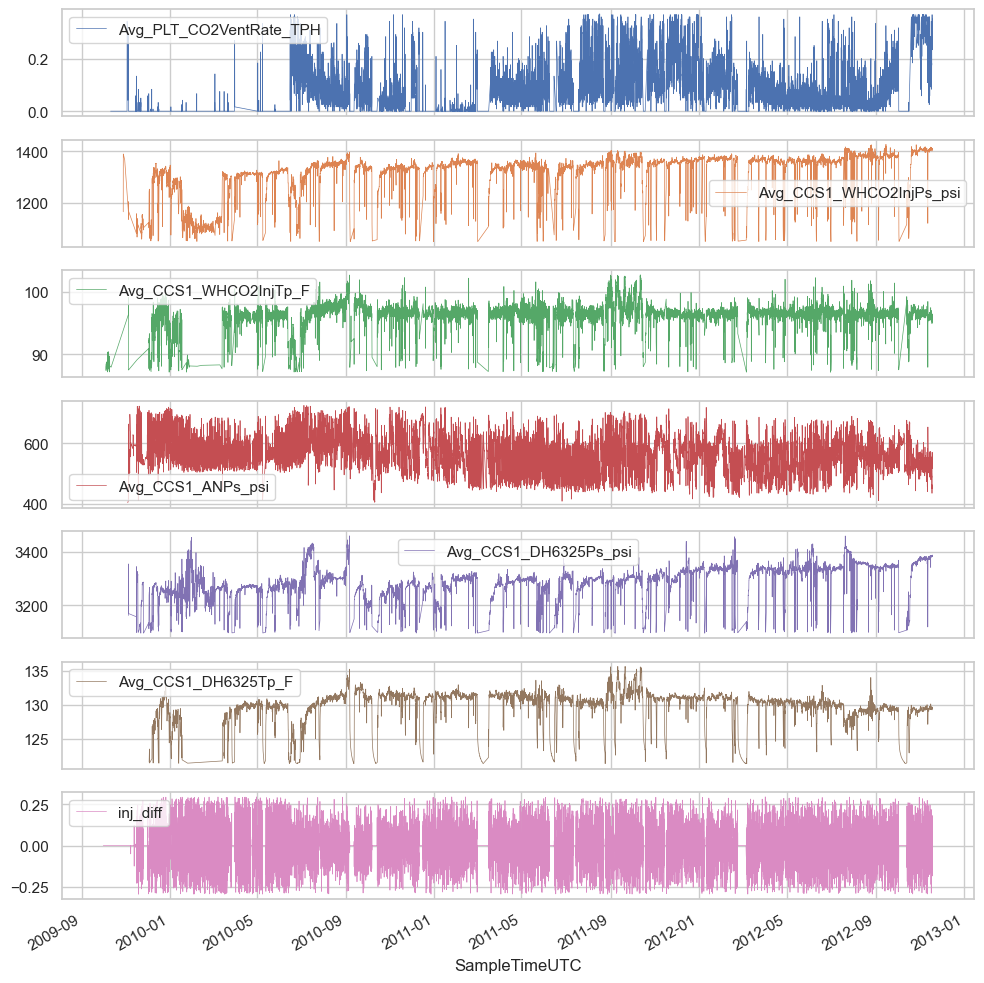

In [9]:
# %% Remove outliers using IQ range for each column
for col in data_train_2.columns:
    data_train_2[col] = remove_outliers_iqr(data_train_2[col])
# %% Interpolate missing values for each column
for col in data_train_2.columns:
    data_train_2[col].interpolate(method="linear", inplace=True)

# %% Plot lineplot of all the columns in the data_train_2 in a different axes
data_train_2.plot(linewidth=0.5, subplots=True, figsize=(10, 10))
plt.tight_layout()
plt.show()

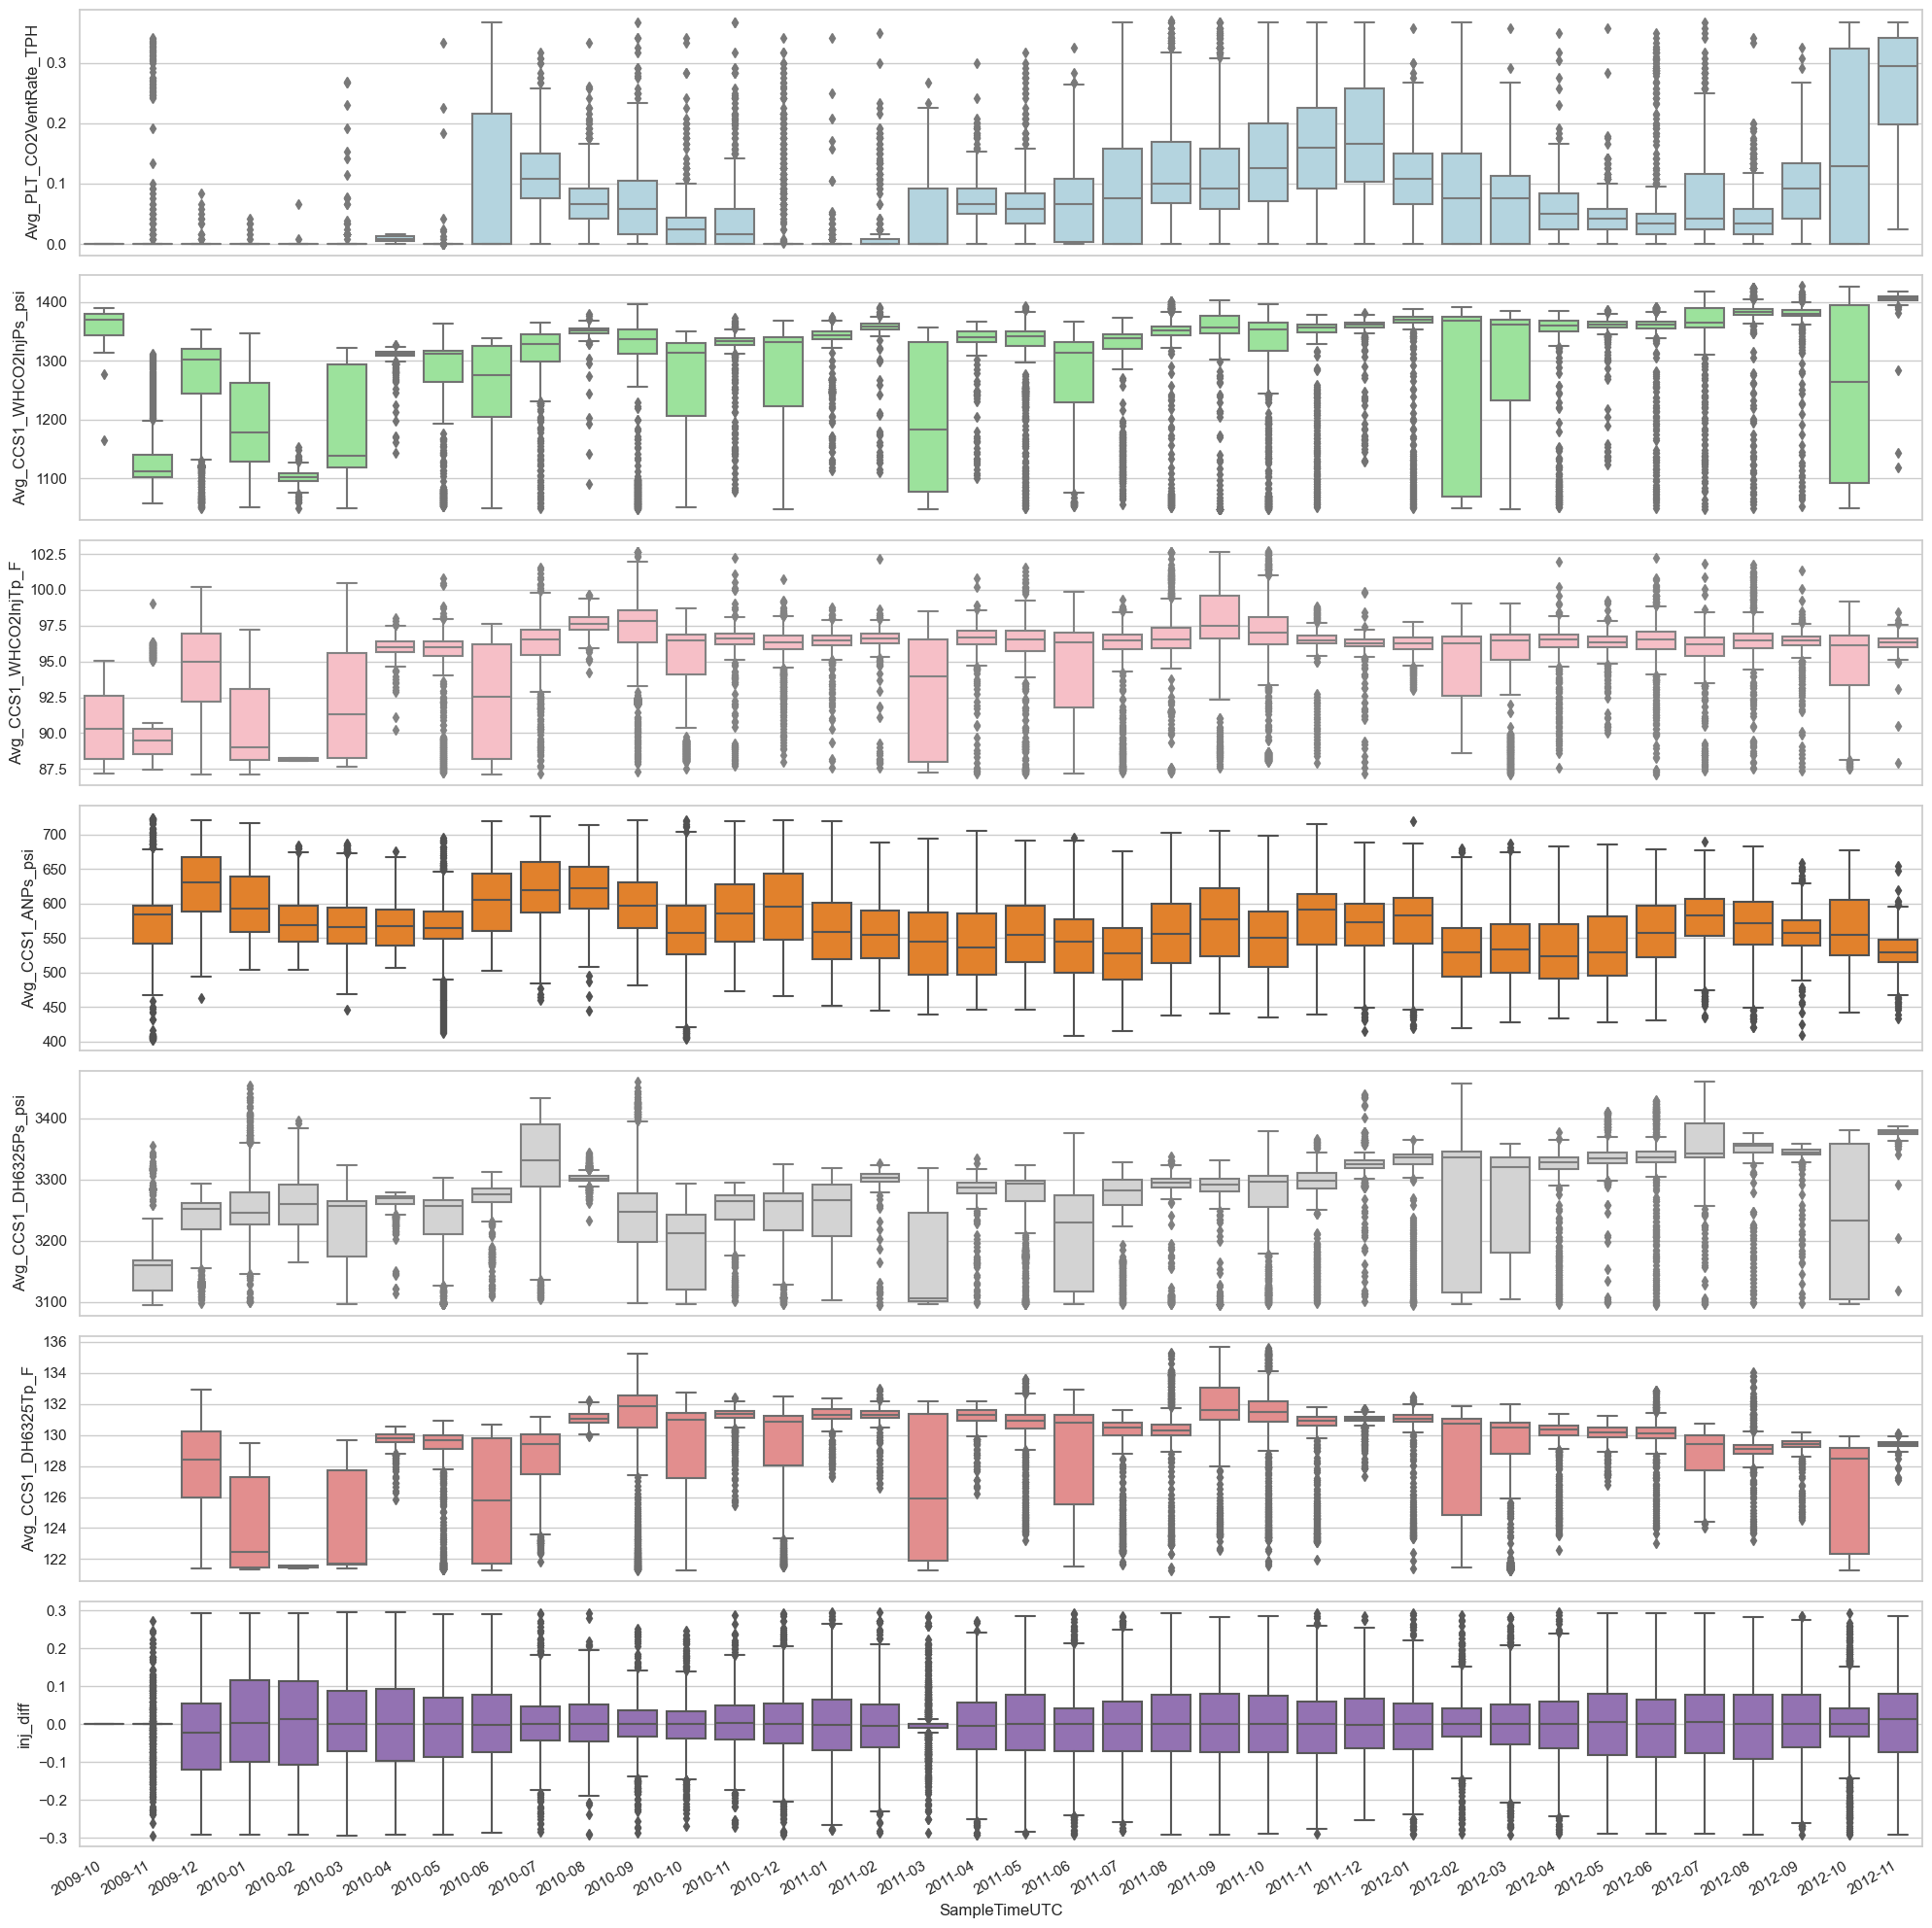

In [10]:
# %% Create boxplot for each column in the data_train_2 in 6 month intervals with
# different colors
fig_3, ax_3 = plt.subplots(7, 1, figsize=(20, 20))
colors = [
    "lightblue",
    "lightgreen",
    "lightpink",
    "tab:orange",
    "lightgray",
    "lightcoral",
    "tab:purple",
]
axs = ax_3.flatten()
for i, col in enumerate(data_train_2.columns):
    sns.boxplot(
        data=data_train_2,
        x=data_train_2.index.to_period("M"),
        y=col,
        ax=axs[i],
        color=colors[i],
    )
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()